In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib

In [2]:
data = pd.read_csv('bank_dataset.csv')

Так как мы работаем с тем же датасетом, что был у нас на основном проекте, я не буду повторять весь этап предобработки данных, только приведу некоторые столбцы к более удобному для работы виду.  

In [3]:
data = data.rename(columns={'userid': 'Userid', 'score':'Score'})

In [4]:
data['Balance'] = data['Balance'].fillna(0)
data['Balance'] = data['Balance'].astype('int')

In [5]:
gender_map = {'Ж':0, 'М':1}
data['Gender'] = data['Gender'].map(gender_map)

## Цель проекта: 
предсказание оттока клиентов на основе имеющихся данных

### Задача:
создание модели бинарной классификации (так как нас интересует категориальный признак "отток", включающий две категории).


## Этапы:
1. Преобразование категорийной переменной в матрицу числовых значений.
2. Разделение датасета на обучающую и тестовую выборки.
3. Выбор модели обучения.
2. Обучение модели на основе имеющихся данных.
4. Оценка качества обученных моделей.
5. Выбор оптимальной модели.
Мы работаем

Мы преобразуем признак "Город" с помощью методов LabelEncoder (присвоение уникального номера каждой категории переменной) и OneHotEncoder (создание матрицы по каждому номеру для решения проблемы присваивания номерам отношений "больше/меньше").

In [6]:
labelencoder = LabelEncoder()
data['City'] = labelencoder.fit_transform(data['City'])

In [7]:
data_train, data_valid = train_test_split(data, test_size=0.25, random_state=11)

In [8]:
#ссылка на сайт, где нашла эту функцию, указана в файле references.txt

def encode_one_hot(train, test, column):

    # создание списка уникальных категорий 
    options = list(set(list(train[column].unique()) + list(test[column].unique())))
    enc = OneHotEncoder(sparse=False)
    enc.fit(np.matrix(options).T)
    original_names = dict((i, a) for i, a in enumerate(train.columns.values))

    oh = pd.DataFrame(enc.transform(np.matrix(train[column]).T))
    oh = oh.set_index(train.index.values)
    train = pd.concat([train, oh], axis=1, ignore_index=True)

    oh = pd.DataFrame(enc.transform(np.matrix(test[column]).T))
    oh = oh.set_index(test.index.values)
    test = pd.concat([test, oh], axis=1, ignore_index=True)

    train = train.rename(columns=original_names)
    test = test.rename(columns=original_names)

    # удаляем столбец, который мы преобразовали
    train = train.drop(column, axis=1)
    test = test.drop(column, axis=1)

    return train, test

In [9]:
train, valid = encode_one_hot(data_train, data_valid, 'City')

In [10]:
train.head()

,Userid,Score,Gender,Age,Objects,Balance,NumOfProducts,CreditCard,IsActiveMember,EstimatedSalary,Churn,12,13,14
2262,15629000,572,1,43,2,140431,1,1,0,26450.57,1,0.0,0.0,1.0
1454,15651389,521,0,34,7,70731,1,1,1,20243.97,1,0.0,1.0,0.0
3901,15757346,575,1,30,2,0,2,1,1,82222.86,0,0.0,1.0,0.0
6246,15814178,633,1,40,4,150578,1,0,1,34670.62,1,0.0,0.0,1.0
1331,15618153,849,1,37,7,143452,2,1,1,17294.12,0,1.0,0.0,0.0


In [11]:
valid.head()

,Userid,Score,Gender,Age,Objects,Balance,NumOfProducts,CreditCard,IsActiveMember,EstimatedSalary,Churn,12,13,14
3104,15696966,526,1,31,5,145537,1,1,0,132404.64,0,1.0,0.0,0.0
6353,15719089,598,1,35,8,114212,1,1,1,74322.85,0,0.0,0.0,1.0
8689,15727505,542,1,67,10,129431,1,0,1,21343.74,0,0.0,0.0,1.0
5857,15856395,594,0,56,7,0,1,1,0,26215.85,1,0.0,0.0,1.0
6011,15825743,520,0,45,1,123086,1,1,1,41042.40,1,1.0,0.0,0.0


## Модель прогнозирования оттока пользователей

In [12]:
features_train = train.drop(['Userid', 'Churn'], axis=1)
target_train = train['Churn']
features_valid = valid.drop(['Userid', 'Churn'], axis=1)
target_valid = valid['Churn']

In [14]:
#таблица для записи метрик качества моделей
verification = pd.DataFrame(columns = ['model', 'n_estimators', 'max_depth', 'accuracy', 'precision', 'recall', 'f_score'])

В качестве алгоритмов бинарной классификации мы можем использовать модель случайного леса и модель логистической регрессии.

In [15]:
#модель случайного леса
#количество деревьев - 2-10, глубина от 2 до 10:
n=0
for i in range(2, 11):
    for j in range(2, 11):
        model_RFC = RandomForestClassifier(random_state=11, n_estimators=i, max_depth=j)
        model_RFC.fit(features_train, target_train)
        prediction_RFC = model_RFC.predict(features_valid)
        accuracy_RFC = accuracy_score(target_valid, prediction_RFC).round(5)
        precision_RFC = precision_score(target_valid, prediction_RFC).round(5)
        recall_RFC = recall_score(target_valid, prediction_RFC).round(5)
        fscore_RFC = 2 * precision_RFC * recall_RFC / (precision_RFC + recall_RFC)
        verification.loc[n] = ['RFC', i, j, accuracy_RFC, precision_RFC, recall_RFC, fscore_RFC]
        n += 1

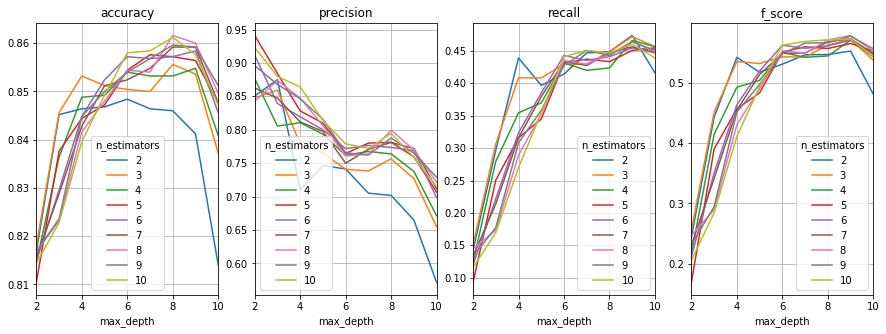

In [16]:
plt.subplots(figsize = (15, 5))
rfc = verification.query('model == "RFC"')
for i, param in enumerate(['accuracy', 'precision', 'recall', 'f_score']):
    pd.pivot_table(verification.query('model == "RFC"'), 
                   index = 'max_depth', 
                   columns = 'n_estimators', 
                   values = param).plot(grid = True, ax = plt.subplot(1, 4, i+1))
    plt.title(param)

На этом графике (код подсказал наставник) мы можем увидеть, как меняются метрики качества в зависимости от глубины и количества деревьев. Мы видим, что __доля правильных ответов, полнота и F-мера__ достигают максимума при глубине 8, хотя при глубине 6 эти метрики также довольно высоки.  
__Точность__ достигает максимума при глубине 2 - 3 (при максимально количестве деревьев). Насколько я понимаю, учитывая, что полнота растет при увеличении глубины, уменьшение значения метрики точности указывает на то, модель относит к положительному классу все больше объектов, которые к нему не принадлежат.

При глубине 8-9 качество метрик начинает снижаться. Количество деревьев при указанной глубине мало влияет на улучшение метрик.

In [18]:
#модель логистической регрессии
model_LG = LogisticRegression(random_state=11)
model_LG.fit(features_train, target_train)
prediction_LG = model_LG.predict(features_valid)
accuracy_LG = accuracy_score(target_valid, prediction_LG).round(5)
precision_LG = precision_score(target_valid, prediction_LG).round(5)
recall_LG = recall_score(target_valid, prediction_LG).round(5)
fscore_LG = 2 * precision_LG * recall_LG / (precision_LG + recall_LG)
verification.loc[len(verification.index)] = ['LR', '', '', accuracy_LG, precision_LG, recall_LG, fscore_LG]


In [19]:
verification.tail()

,model,n_estimators,max_depth,accuracy,precision,recall,f_score
77,RFC,10,7,0.8584,0.77228,0.45087,0.569346
78,RFC,10,8,0.8612,0.79452,0.44701,0.572130
79,RFC,10,9,0.8576,0.75873,0.46050,0.573141
80,RFC,10,10,0.8472,0.71473,0.43931,0.544155
81,LR,,,0.7840,0.37037,0.05780,0.099995


In [20]:
print('Лучшая доля правильных ответов:','\n', verification[verification['accuracy'] == verification['accuracy'].max()])
print()
print('Лучшая точность:','\n', verification[verification['precision'] == verification['precision'].max()])
print()
print('Лучшая полнота:','\n', verification[verification['recall'] == verification['recall'].max()])
print()
print('Лучшая F-мера:','\n', verification[verification['f_score'] == verification['f_score'].max()])

Лучшая доля правильных ответов: 
    model n_estimators max_depth  accuracy  precision   recall   f_score
60   RFC            8         8    0.8616    0.79931  0.44509  0.571785

Лучшая точность: 
    model n_estimators max_depth  accuracy  precision   recall   f_score
27   RFC            5         2    0.8104    0.94118  0.09249  0.168428

Лучшая полнота: 
   model n_estimators max_depth  accuracy  precision   recall  f_score
7   RFC            2         9    0.8412    0.66486  0.47399  0.55343

Лучшая F-мера: 
    model n_estimators max_depth  accuracy  precision   recall   f_score
61   RFC            8         9      0.86    0.76997  0.46435  0.579324


Чтобы посмотреть, не произошло ли переобучения, сравним предсказания лучшей модели по параметру F-мера (RFC, n_estimators=8, max_depth=9) на обучающей и тестовой выборке.

In [21]:
verification_ = pd.DataFrame(columns = ['sample', 'accuracy', 'precision', 'recall', 'f_score'])

In [22]:
samples = ['обучающая', 'тестовая']
n = 0
for i in [[features_train, target_train], [features_valid, target_valid]]:
        model_RFC = RandomForestClassifier(random_state=11, n_estimators=8, max_depth=9)
        model_RFC.fit(features_train, target_train)
        prediction_RFC = model_RFC.predict(i[0])
        accuracy_RFC = accuracy_score(i[1], prediction_RFC).round(5)
        precision_RFC = precision_score(i[1], prediction_RFC).round(5)
        recall_RFC = recall_score(i[1], prediction_RFC).round(5)
        fscore_RFC = 2 * precision_RFC * recall_RFC / (precision_RFC + recall_RFC)
        verification_.loc[n] = [samples[n], accuracy_RFC, precision_RFC, recall_RFC, fscore_RFC]
        n += 1


In [23]:
print(verification_)

      sample  accuracy  precision   recall   f_score
0  обучающая   0.88733    0.88992  0.50593  0.645108
1   тестовая   0.86000    0.76997  0.46435  0.579324


Учитывая, что в любом случае на обучающей выборке критерии качества будут выше, мы видим, что f-мера на тестовой выборке показывает хороший результат, больше 0,5, и можем заключить, что модель не переобучена.

Таким образом, для предсказания оттока клиентов в банке выбираем модель случайного леса со следующеми параметрами:  
- число деревьев - 8, максимальная глубина - 9.

In [24]:
joblib.dump(model_RFC, 'best_model.joblib')

['best_model.joblib']